In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchtext import data, datasets
import spacy

In [2]:
SEED = 947
torch_utils.seed_everything(SEED)

In [3]:
spacy_de = spacy.load("de")
spacy_en = spacy.load("en")

In [4]:
def tokenize_de(txt):
    return [tok.text for tok in spacy_de.tokenizer(txt)]
def tokenize_en(txt):
    return [tok.text for tok in spacy_en.tokenizer(txt)]

In [5]:
SRC = data.Field(
    tokenize=tokenize_de,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True,
    batch_first=True
)
TRG = data.Field(
    tokenize=tokenize_en,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True,
    batch_first=True
)

In [6]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=(".de",".en"), fields=(SRC, TRG))
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [7]:
BATCH_SIZE=150
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
(train_data, valid_data, test_data),
batch_size=BATCH_SIZE,
    device=device
)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, pos_dim=100):
        super(Encoder, self).__init__()
        
        assert kernel_size%2 == 1, "Kernel size must be odd!"
        
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(pos_dim, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(
            in_channels=hid_dim,
            out_channels=2*hid_dim,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # src -- batch_size X seq_len
        batch_size, seq_len = src.shape
        
        # tensor for the positions
        pos = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos -- batch_size X seq_len
        
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        embedded = self.dropout(tok_embedded+pos_embedded)
        # combined the positional and token embeddings
        # embedded --- batch_size X seq_len X emb_dim
        
        
        conv_input = self.emb2hid(embedded)
        # conv_input -- batch_size X seq_len X hid_dim
        
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input -- batch_size X hid_dim X seq_len; hid_dim -- works like channel dimension here for 1d CNN
        
        for i, conv in enumerate(self.convs):
            conved = conv(self.dropout(conv_input))
            # conved -- batch_size X 2*hid_dim X seq_len
            conved = F.glu(conved, dim=1)
            # conved -- batch_size X hid_dim X seq_len
            conved = (conved+conv_input)*self.scale
            # residual connection and rescaling inside convolutional blocks
            conv_input = conved
            # pass for the next layer
        
        # conved -- batch_size X hid_dim X seq_len
        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved --  batch_size X seq_len X emb_dim
        
        combined = (conved+embedded)*self.scale
        # residual and rescaling outside the convolutional blocks
        return conved, combined

In [9]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, trg_pad_idx, device, pos_dim=100):
        super(Decoder, self).__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(pos_dim, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim*2, kernel_size=kernel_size) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, encoder_conved, encoder_combined):
        batch_size, seq_len = trg.shape
        pos = torch.arange(0, seq_len).unsqueeze(dim=0).repeat(batch_size, 1).to(self.device)
        # pos -- batch_size X seq_len
        # trg -- batch_size X seq_len
        # encoder_conved | encoder_combined -- batch_size X seq_len X emb_dim
        
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        embedded = self.dropout(tok_embedded+pos_embedded)
        # embedded -- batch_size X seq_len X emb_dim
        
        conv_input = self.emb2hid(embedded)
        # conv_input -- batch_size X seq_len X hid_dim
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input -- batch_size X hid_dim X seq_len
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            conv_input = self.dropout(conv_input)
            
            padding = torch.zeros(batch_size, hid_dim, self.kernel_size-1).fill_(self.trg_pad_idx).to(device)
            padded_conv_input = torch.cat((padding, conv_input), dim=2)
            # padded_conv_input --  batch_size X hidden_dim X seq_len + kernel_size-1
            
            conved = conv(padded_conv_input)
            # conved -- batch_size X 2*hidden_dim X seq_len
            conved = F.glu(conved, dim=1)
            # conved -- batch_size X hidden_dim X seq_len
            
            # calculate and apply attention
            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            # attention -- batch_size X trg_len X src_len
            
            conved = (conved+conv_input)*self.scale
            # conved --  batch_size X hid_dim X trg_len
            conv_input = conved
        
        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))
        # output -- batch_size X trg_len X output_dim
        
        return output, attention
    
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        # embedded --  batch_size X trg_len X emb_dim
        # conved -- batch_size X hid_dim X trg_len
        # encoder_conved | encoder_combined --  batch_size X src_len X emb_dim
        
        conved_emb = self.attn_hid2emb(conved.permute(0,2,1))
        combined = (conved_emb+embedded)*self.scale
        # combined -- batch_size X trg_len X emb_dim
        
        energy = torch.matmul(combined, encoder_conved.permute(0,2,1))
        # energy --  batch_size X trg_len X src_len
        attention = F.softmax(energy, dim=2)
        # attention -- batch_size X trg_len X src_len
        
        attended_encoding = torch.matmul(attention, encoder_combined)
        # attended_encoding -- batch_size X trg_len X emb_dim
        
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        attended_combined = (conved+attended_encoding.permute(0,2,1))*self.scale
        
        return attention, attended_combined
                

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        encoder_conved, encoder_combined = self.encoder(src)
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        return output, attention

In [11]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    el = 0
    
    for batch in tqdm(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        # output -- batch_size X trg_len-1 X output_dim
        # trg -- batch_size X trg_len
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        el+=loss.item()
    return el/len(iterator)

In [12]:
def evaluate(model, iterator, criterion):
    model.eval()
    el = 0
    with torch.no_grad():
        for batch in tqdm(iterator):
            src = batch.src
            trg = batch.trg
            output,_ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            el+=loss.item()
    return el/len(iterator)

In [13]:
torch_utils.clear_cuda()

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512
ENC_LAYERS = 10
DEC_LAYERS = 10
ENC_KERNEL_SIZE = 3
DEC_KERNEL_SIZE = 3
DEC_DROPOUT = 0.25
ENC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]


enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)
torch_utils.count_model_params(model)

37351685

In [15]:
optimizer = torch_utils.RAdam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
clip = 1
n_epochs = 50
ea = torch_utils.EarlyStopping(patience=5, verbose=True, save_model_name="CONV_SEQ2SEQ.pt")
history = pd.DataFrame()

In [16]:
for e in range(n_epochs):
    st = time.time()
    tl = train(model, train_iterator, optimizer, criterion, clip)
    vl = evaluate(model, valid_iterator, criterion)
    TPL, VPL = np.exp(tl), np.exp(vl)
    ea(VPL, model)
    torch_utils.print_epoch_stat(e, time.time()-st, history, tl,valid_loss=vl)
    print(f"\t\tTPL\t\t{TPL}")
    print(f"\t\tVPL\t\t{VPL}")
    history.loc[e, "TPL"] = TPL
    history.loc[e, "VPL"] = VPL
    if ea.early_stop:
        print("STOPPING EARLY...")
        break


Found better solution (inf --> 76.761877).  Saving model ...


EPOCH 1 Completed, Time Taken: 0:00:43.406811
	Train Loss 	5.25786514
	Valid Loss 	4.34070812
		TPL		192.07100789283214
		VPL		76.76187668129084



Found better solution (76.761877 --> 29.627161).  Saving model ...


EPOCH 2 Completed, Time Taken: 0:00:44.946920
	Train Loss 	3.77635045
	Valid Loss 	3.38869153
		TPL		43.65642419427848
		VPL		29.627160572191823



Found better solution (29.627161 --> 16.592813).  Saving model ...


EPOCH 3 Completed, Time Taken: 0:00:44.333252
	Train Loss 	3.20838361
	Valid Loss 	2.80896967
		TPL		24.739066015600745
		VPL		16.59281330157562



Found better solution (16.592813 --> 12.420879).  Saving model ...


EPOCH 4 Completed, Time Taken: 0:00:43.485921
	Train Loss 	2.82040775
	Valid Loss 	2.51937883
		TPL		16.783692777389106
		VPL		12.420878819406065



Found better solution (12.420879 --> 9.673391).  Saving model ...


EPOCH 5 Completed, Time Taken: 0:00:45.640852
	Train Loss 	2.56207893
	Valid Loss 	2.2693789
		TPL		12.962737892530084
		VPL		9.673390809935901



Found better solution (9.673391 --> 8.215999).  Saving model ...


EPOCH 6 Completed, Time Taken: 0:00:44.374917
	Train Loss 	2.36959805
	Valid Loss 	2.10608329
		TPL		10.693093286320993
		VPL		8.215998507081256



Found better solution (8.215999 --> 7.243209).  Saving model ...


EPOCH 7 Completed, Time Taken: 0:00:45.973304
	Train Loss 	2.22358339
	Valid Loss 	1.98006432
		TPL		9.240383529014006
		VPL		7.243208882129327



Found better solution (7.243209 --> 6.711323).  Saving model ...


EPOCH 8 Completed, Time Taken: 0:00:44.530915
	Train Loss 	2.10997769
	Valid Loss 	1.90379603
		TPL		8.248057265121064
		VPL		6.7113225015573175



Found better solution (6.711323 --> 6.456398).  Saving model ...


EPOCH 9 Completed, Time Taken: 0:00:45.215912
	Train Loss 	2.02106518
	Valid Loss 	1.86507155
		TPL		7.546358901957769
		VPL		6.4563978385486225



Found better solution (6.456398 --> 6.278736).  Saving model ...


EPOCH 10 Completed, Time Taken: 0:00:44.711310
	Train Loss 	1.94385941
	Valid Loss 	1.83716871
		TPL		6.985659557656762
		VPL		6.2787361521710015



Found better solution (6.278736 --> 6.087907).  Saving model ...


EPOCH 11 Completed, Time Taken: 0:00:44.683562
	Train Loss 	1.88682739
	Valid Loss 	1.80630432
		TPL		6.598401285487674
		VPL		6.0879068421665465



Found better solution (6.087907 --> 5.913901).  Saving model ...


EPOCH 12 Completed, Time Taken: 0:00:44.549621
	Train Loss 	1.83977356
	Valid Loss 	1.77730574
		TPL		6.295112659464675
		VPL		5.913901342506474



Found better solution (5.913901 --> 5.764649).  Saving model ...


EPOCH 13 Completed, Time Taken: 0:00:44.984743
	Train Loss 	1.79222936
	Valid Loss 	1.75174432
		TPL		6.002819999221296
		VPL		5.764649312419013



Found better solution (5.764649 --> 5.749224).  Saving model ...


EPOCH 14 Completed, Time Taken: 0:00:44.870945
	Train Loss 	1.75794725
	Valid Loss 	1.74906491
		TPL		5.800518123552298
		VPL		5.749224092693566



Found better solution (5.749224 --> 5.744068).  Saving model ...


EPOCH 15 Completed, Time Taken: 0:00:44.328849
	Train Loss 	1.72929745
	Valid Loss 	1.74816769
		TPL		5.636692485938396
		VPL		5.744068086069402



Found better solution (5.744068 --> 5.654664).  Saving model ...


EPOCH 16 Completed, Time Taken: 0:00:43.943028
	Train Loss 	1.70044248
	Valid Loss 	1.73248071
		TPL		5.476370030137328
		VPL		5.654664124075255



Found better solution (5.654664 --> 5.597564).  Saving model ...


EPOCH 17 Completed, Time Taken: 0:00:43.041304
	Train Loss 	1.67678184
	Valid Loss 	1.72233144
		TPL		5.348316533994793
		VPL		5.59756363976662



Found better solution (5.597564 --> 5.533924).  Saving model ...


EPOCH 18 Completed, Time Taken: 0:00:43.154055
	Train Loss 	1.65235981
	Valid Loss 	1.71089717
		TPL		5.219281842545957
		VPL		5.533924139538169



Found better solution (5.533924 --> 5.491159).  Saving model ...


EPOCH 19 Completed, Time Taken: 0:00:42.921600
	Train Loss 	1.63517041
	Valid Loss 	1.70313927
		TPL		5.130332169705801
		VPL		5.491158597515707



EarlyStopping counter: 1 out of 5


EPOCH 20 Completed, Time Taken: 0:00:41.586191
	Train Loss 	1.61594724
	Valid Loss 	1.70474463
		TPL		5.032652813917368
		VPL		5.499980949458083



EarlyStopping counter: 2 out of 5


EPOCH 21 Completed, Time Taken: 0:00:41.531370
	Train Loss 	1.599376
	Valid Loss 	1.70423186
		TPL		4.9499426844867065
		VPL		5.497161445824902



Found better solution (5.491159 --> 5.470190).  Saving model ...


EPOCH 22 Completed, Time Taken: 0:00:43.316785
	Train Loss 	1.58471505
	Valid Loss 	1.69931335
		TPL		4.877901204062915
		VPL		5.470190001847984



Found better solution (5.470190 --> 5.462437).  Saving model ...


EPOCH 23 Completed, Time Taken: 0:00:43.072351
	Train Loss 	1.56790534
	Valid Loss 	1.6978951
		TPL		4.796590458159523
		VPL		5.462437404024256



EarlyStopping counter: 1 out of 5


EPOCH 24 Completed, Time Taken: 0:00:41.686441
	Train Loss 	1.55658699
	Valid Loss 	1.704422
		TPL		4.742607005800818
		VPL		5.498206768973257



Found better solution (5.462437 --> 5.441186).  Saving model ...


EPOCH 25 Completed, Time Taken: 0:00:43.182495
	Train Loss 	1.539233
	Valid Loss 	1.69399709
		TPL		4.661013907729095
		VPL		5.441186227427541



Found better solution (5.441186 --> 5.393391).  Saving model ...


EPOCH 26 Completed, Time Taken: 0:00:43.043581
	Train Loss 	1.53081476
	Valid Loss 	1.68517423
		TPL		4.621941081771344
		VPL		5.3933905234571515



EarlyStopping counter: 1 out of 5


EPOCH 27 Completed, Time Taken: 0:00:41.739813
	Train Loss 	1.52323722
	Valid Loss 	1.69686966
		TPL		4.5870504820693725
		VPL		5.4568388824110565



EarlyStopping counter: 2 out of 5


EPOCH 28 Completed, Time Taken: 0:00:43.023058
	Train Loss 	1.50837066
	Valid Loss 	1.6947443
		TPL		4.519361213457115
		VPL		5.445253421921988



Found better solution (5.393391 --> 5.362787).  Saving model ...


EPOCH 29 Completed, Time Taken: 0:00:45.050528
	Train Loss 	1.49792188
	Valid Loss 	1.67948387
		TPL		4.472385274125363
		VPL		5.36278738005015



EarlyStopping counter: 1 out of 5


EPOCH 30 Completed, Time Taken: 0:00:44.246634
	Train Loss 	1.48608781
	Valid Loss 	1.68276014
		TPL		4.419770651009952
		VPL		5.380386094997114



EarlyStopping counter: 2 out of 5


EPOCH 31 Completed, Time Taken: 0:00:43.669583
	Train Loss 	1.47676282
	Valid Loss 	1.68544945
		TPL		4.3787479318874345
		VPL		5.394875097703584



EarlyStopping counter: 3 out of 5


EPOCH 32 Completed, Time Taken: 0:00:43.990112
	Train Loss 	1.46593349
	Valid Loss 	1.68176694
		TPL		4.331584836956496
		VPL		5.375044944559229



EarlyStopping counter: 4 out of 5


EPOCH 33 Completed, Time Taken: 0:00:43.583488
	Train Loss 	1.45501879
	Valid Loss 	1.68786798
		TPL		4.284563988080762
		VPL		5.407938583349117



EarlyStopping counter: 5 out of 5


EPOCH 34 Completed, Time Taken: 0:00:43.871029
	Train Loss 	1.44792365
	Valid Loss 	1.68947557
		TPL		4.25427196160712
		VPL		5.416639314186455
STOPPING EARLY...


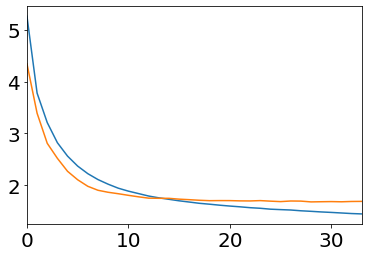

In [17]:
ax = history["train_loss"].plot()
history["valid_loss"].plot(ax=ax)

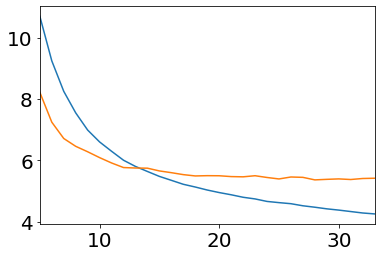

In [18]:
ax = history.loc[5:,"TPL"].plot()
history.loc[5:,"VPL"].plot(ax=ax)

In [19]:
model.load_state_dict(torch.load(ea.save_model_name, map_location=device))

<All keys matched successfully>

In [20]:
test_loss = evaluate(model, test_iterator, criterion)

print(f"TEST LOSS: {test_loss:.5f} TEST Perplexity: {np.exp(test_loss):.5f}")


TEST LOSS: 1.76276 TEST Perplexity: 5.82852


In [21]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load("de")
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token]+tokens+[src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(dim=0).to(device)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(dim=0).to(device)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        pred_token = output.argmax(dim=2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [22]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(dim=0).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap="bone")
    
    ax.tick_params(labelsize=10)
    ax.set_xticklabels([""]+["<sos>"]+[t.lower() for t in sentence]+["<eos>"], rotation=45)
    ax.set_yticklabels([""]+translation)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

src == ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg == ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']
predicted == ['a', 'little', 'girl', 'climbs', 'out', 'of', 'wood', '.', '<eos>']


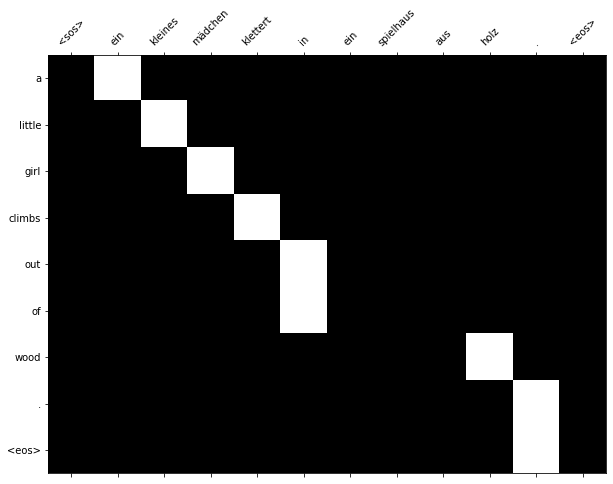

In [23]:
example_idx = 2
src = vars(train_data.examples[example_idx])["src"]
trg = vars(train_data.examples[example_idx])["trg"]

print(f'src == {src}')
print(f'trg == {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f"predicted == {translation}")
display_attention(src, translation, attention)

src == ['ein', 'kind', 'in', 'einem', 'roten', 'sweatshirt', 'hängt', 'kopfüber', 'an', 'einem', 'baum', '.']
trg == ['a', 'child', 'wearing', 'a', 'red', 'sweatshirt', 'is', 'hanging', 'upside', 'down', 'from', 'a', 'tree', '.']
predicted == ['a', 'child', 'in', 'a', 'red', 'sweatshirt', 'is', 'hanging', 'upside', 'down', 'from', 'a', 'tree', '.', '<eos>']


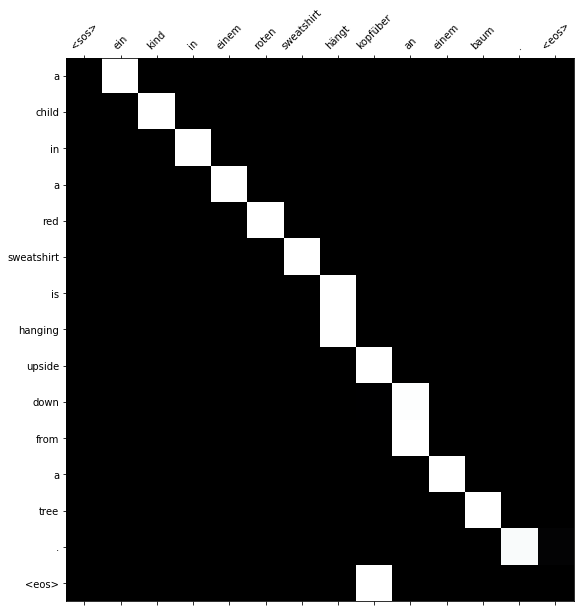

In [24]:
example_idx = 234
src = vars(valid_data.examples[example_idx])["src"]
trg = vars(valid_data.examples[example_idx])["trg"]

print(f'src == {src}')
print(f'trg == {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f"predicted == {translation}")
display_attention(src, translation, attention)

src == ['ein', 'mann', 'in', 'einer', 'weste', 'sitzt', 'auf', 'einem', 'stuhl', 'und', 'hält', 'magazine', '.']
trg == ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'in', 'a', 'chair', 'and', 'holding', 'magazines', '.']
predicted == ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'on', 'a', 'chair', 'holding', '<unk>', '.', '<eos>']


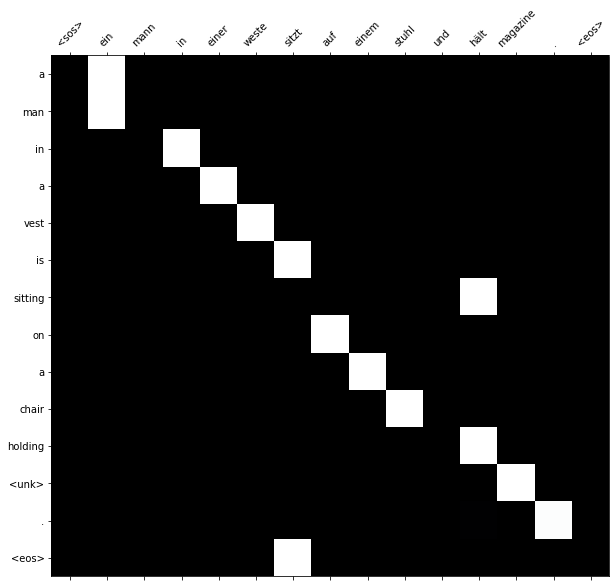

In [25]:
example_idx = 9
src = vars(test_data.examples[example_idx])["src"]
trg = vars(test_data.examples[example_idx])["trg"]

print(f'src == {src}')
print(f'trg == {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f"predicted == {translation}")
display_attention(src, translation, attention)

In [26]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    preds = []
    
    for d in tqdm(data):
        pred, _ = translate_sentence(vars(d)["src"],src_field, trg_field, model, device, max_len)
        pred = pred[:-1]
        preds.append(pred)
        trgs.append([vars(d)["trg"]])
    return torch_utils.bleu_score(preds, trgs)

In [27]:
100.0*calculate_bleu(test_data, SRC, TRG, model, device)

37.176697438751965

In [28]:
100.0*calculate_bleu(valid_data, SRC, TRG, model, device)

36.869325242602386

In [29]:
100.0*calculate_bleu(train_data[:500], SRC, TRG, model, device)

47.970866900878015

In [30]:
100.0*calculate_bleu(train_data[-500:], SRC, TRG, model, device)

43.838256980591915